In [1]:

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import Dataset
import torch.optim as optim
from torchvision import transforms
import numpy as np
import torch
from torch import nn
import os
from torch.utils.data import DataLoader, random_split
from torch.nn import DataParallel
from torch.utils.data import Subset
import shutil

# import sys
# sys.path.append('D:\\Downloads\\fresh_projects\\SegmAIParserClothes')

# from codes.metrics import RMSELoss

In [2]:
# Hyperparameters
# We can adjust the learning_rate here to improve the model performance, scheduler is used to reduce the learning rate at specific epochs
# The batch size can be adjusted based on the available memory
# If apply_augmentations is set to True, the model will apply augmentations to the images to improve the model performance
load_saved_model = False # Set to True to load a saved model otherwise, set to False to train a new model
apply_augmentations = False # Set to True to apply augmentations
training_epoch = 5
batch_size = 1
learning_rate = 0.0005
momentum = 0.9 
weight_decay = 0.05
scheduler = 1
TrainedEpochCountModel = 5

# check if load_saved_model so using the number of TrainedEpochCountModel for the logs
TrainedEpochCountModel = TrainedEpochCountModel if load_saved_model else 0

device = "cuda"
logdir = "logs/"
resultdir = "logs/results/"

# Make result directory
if os.path.exists(resultdir):
    shutil.rmtree(resultdir)
os.makedirs(resultdir)

In [3]:
class Fashion_Data(Dataset):
    """
    A custom dataset class for loading fashion-related training and ground truth images.
    """
    def __init__(self, folder_train, folder_ground_truth, augmentation=None):
        """
        Initializes the dataset object.

        Args:
            folder_train (str): Path to the directory containing training images.
            folder_ground_truth (str): Path to the directory containing ground truth images.
            augmentation (callable, optional): Data augmentation pipeline. Defaults to None.

        The transformation pipeline converts images to PyTorch tensors by default. 
        We have to return this into a Tensor
        Tensor is a multi-dimensional matrix containing elements of a single data type that represent image, data, etc.
        """
        self.folder_train = folder_train
        self.folder_ground_truth = folder_ground_truth
        # self.transform = transforms.Compose([transforms.ToTensor()]) if augmentation is None else transforms.Compose([augmentation, transforms.ToTensor()]) 
        self.transform = transforms.Compose([transforms.Resize((512, 384)), transforms.ToTensor()]) if augmentation is None else transforms.Compose([augmentation, transforms.Resize((512, 384)), transforms.ToTensor()])
        self.filenames = [f for f in os.listdir(folder_train) if os.path.isfile(os.path.join(folder_train, f))]
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        """
        Retrieves the image and its corresponding ground truth by index.

        Args:
            idx (int): Index of the dataset item to fetch.

        Returns:
            tuple: A tuple containing the transformed training image and its ground truth.
        """
        img_name_train = os.path.join(self.folder_train, self.filenames[idx])
        img_name_gt = os.path.join(self.folder_ground_truth, self.filenames[idx])

        img_train = Image.open(img_name_train).convert('L')
        img_gt = Image.open(img_name_gt).convert('L')

        img_train = self.transform(img_train)
        img_gt = self.transform(img_gt)

        return img_train, img_gt

In [4]:
train_folder = "dataset/upper/cloth_align"
gt_folder = "dataset/upper/cloth_align_parse-bytedance"

full_set = Fashion_Data(train_folder, gt_folder)

# We want to validate model using fraction dataset (how many percent parts of the dataset will be used)
fraction_size = 1

# Calculate sizes
full_dataset_size = len(full_set)
subset_size = int(fraction_size * full_dataset_size)  # Total size of the subset to use

# Create indices for the subset
subset_indices = torch.randperm(full_dataset_size)[:subset_size].tolist()

# Create a subset based on the indices
subset = Subset(full_set, subset_indices)

# Now, calculate train and test sizes for the subset
train_size = int(0.999 * len(subset))  # 90% of the subset size
test_size = len(subset) - train_size  # The rest for testing

# Split the subset into train and test
train_dataset, test_dataset = random_split(subset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

print(len(train_dataset))

499


In [5]:
# Section for data augmentation
# Including augmentations to the dataset can help improve the model's performance
# These are geometry augmentation and color-wise augmentation
# You can enable apply_augmentations to apply the augmentations to the dataset
import copy
from albumentations import (
    Compose, GridDistortion, RandomBrightnessContrast, RGBShift, ShiftScaleRotate,
    ColorJitter, GaussNoise,
    HueSaturationValue,
    OpticalDistortion,
    # IAASharpen,
    CLAHE,
    ToGray
)

augmentations = {
    "augmentation1": Compose([
        RandomBrightnessContrast(p=0.5),
        RGBShift(p=0.5),
        ColorJitter(p=0.5),
        GaussNoise(p=0.5)
    ]),
    "augmentation2": Compose([
        RandomBrightnessContrast(p=0.5),
        RGBShift(p=0.5),
    ]),
    "augmentation3": Compose([
        ToGray(always_apply=True),
    ]),
    "augmentation4": Compose([
        CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
        RandomBrightnessContrast(brightness_limit=(0.6, 0.8), contrast_limit=0.2, p=0.9),
    ]),
    "augmentation5": Compose([
        RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.5),
        ColorJitter(brightness=0.5, p=0.5)
    ]),
    "augmentation6": Compose([
        GaussNoise(var_limit=(20.0, 70.0), p=0.5),
        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
    ]),
    "augmentation7": Compose([
        HueSaturationValue(hue_shift_limit=20, sat_shift_limit=0, val_shift_limit=-20, p=0.5),
        RandomBrightnessContrast(brightness_limit=-0.3, contrast_limit=0.3, p=0.5),
        GaussNoise(var_limit=(10.0, 30.0), p=0.5)
    ]),
    "augmentation8": Compose([
        OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.5),
        RandomBrightnessContrast(brightness_limit=-0.4, contrast_limit=0.4, p=0.5),
        ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5)
    ]),
    # "augmentation9": Compose([
    #     IAASharpen(alpha=(0.1, 0.3), lightness=(0.5, 1.0), p=0.5),
    #     RandomBrightnessContrast(brightness_limit=-0.5, contrast_limit=0.5, p=0.5),
    #     RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.5)
    # ]),
    "augmentation9": Compose([
        CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
        RandomBrightnessContrast(brightness_limit=(-0.7, -0.9), contrast_limit=0.4, p=0.9),
        ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2, p=0.5)
    ])
   , "augmentation10": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-45, 45), p=0.5)
]),

"augmentation11": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-60, 60), p=0.5)
]),

"augmentation12": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-75, 75), p=0.5)
]),

"augmentation13": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-90, 90), p=0.5)
]),

"augmentation14": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-105, 105), p=0.5)
]),

"augmentation15": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-120, 120), p=0.5)
]),

"augmentation16": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-135, 135), p=0.5)
]),

"augmentation17": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-150, 150), p=0.5)
]),

"augmentation18": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-165, 165), p=0.5)
]),

"augmentation19": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-180, 180), p=0.5)
]),

"augmentation20": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-195, 195), p=0.5)
]),

"augmentation21": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-210, 210), p=0.5)
]),

"augmentation22": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-225, 225), p=0.5)
]),

"augmentation23": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-240, 240), p=0.5)
]),

"augmentation24": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-255, 255), p=0.5)
]),

"augmentation25": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-270, 270), p=0.5)
]),

"augmentation26": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-285, 285), p=0.5)
]),

"augmentation27": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-300, 300), p=0.5)
]),

"augmentation28": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-315, 315), p=0.5)
]),
"augmentation29": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-45, 45), p=0.5),
    RandomBrightnessContrast(p=0.5),
]),

"augmentation30": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-60, 60), p=0.5),
    RandomBrightnessContrast(p=0.5),
]),

"augmentation31": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-75, 75), p=0.5),
    RandomBrightnessContrast(p=0.5),
]),

"augmentation32": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-90, 90), p=0.5),
    RandomBrightnessContrast(p=0.5),
]),

"augmentation33": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-105, 105), p=0.5),
    RandomBrightnessContrast(p=0.5),
]),

"augmentation34": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-120, 120), p=0.5),
    RandomBrightnessContrast(p=0.5),
]),

"augmentation35": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-135, 135), p=0.5),
    RandomBrightnessContrast(p=0.5),
]),

"augmentation36": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-150, 150), p=0.5),
    RandomBrightnessContrast(p=0.5),
]),

"augmentation37": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-165, 165), p=0.5),
    RandomBrightnessContrast(p=0.5),
]),

"augmentation38": Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=(-180, 180), p=0.5),
    RandomBrightnessContrast(p=0.5),
])


}


# if apply_augmentations:

#     dataset_size = len(train_dataset)
#     sixth = dataset_size // 37
#     sizes = [sixth] * 9  # Size for each of the first five splits
#     sizes.append(dataset_size - sum(sizes))  # The size for the last split to cover all remaining data

if apply_augmentations:
    dataset_size = len(train_dataset)
    num_augmentations = 38  # Update this number if needed
    sixth = dataset_size // num_augmentations
    sizes = [sixth] * (num_augmentations - 1)  # Size for each of the first n-1 splits
    sizes.append(dataset_size - sum(sizes))  # The size for the last split to cover all remaining data


    # Randomly split the dataset into 6 parts
    train_dataset1, \
    train_dataset2, \
    train_dataset3, \
    train_dataset4, \
    train_dataset5, \
    train_dataset6, \
    train_dataset7, \
    train_dataset8, \
    train_dataset9, \
    train_dataset10, \
    train_dataset11, \
    train_dataset12, \
    train_dataset13, \
    train_dataset14, \
    train_dataset15, \
    train_dataset16, \
    train_dataset17, \
    train_dataset18, \
    train_dataset19, \
    train_dataset20, \
    train_dataset21, \
    train_dataset22, \
    train_dataset23, \
    train_dataset24, \
    train_dataset25, \
    train_dataset26, \
    train_dataset27, \
    train_dataset28, \
    train_dataset29, \
    train_dataset30, \
    train_dataset31, \
    train_dataset32, \
    train_dataset33, \
    train_dataset34, \
    train_dataset35, \
    train_dataset36, \
    train_dataset37, \
    train_dataset38 \
    = random_split(
    train_dataset,
    sizes,
    generator=torch.Generator().manual_seed(42)
    )
    
    train_dataset1.dataset.transform = augmentations["augmentation1"]
    train_dataset2.dataset.transform = augmentations["augmentation2"]
    train_dataset3.dataset.transform = augmentations["augmentation3"]
    train_dataset4.dataset.transform = augmentations["augmentation4"]
    train_dataset5.dataset.transform = augmentations["augmentation5"]
    train_dataset6.dataset.transform = augmentations["augmentation6"]
    train_dataset7.dataset.transform = augmentations["augmentation7"]
    train_dataset8.dataset.transform = augmentations["augmentation8"]
    train_dataset9.dataset.transform = augmentations["augmentation9"]
    train_dataset11.dataset.transform = augmentations["augmentation10"]
    train_dataset12.dataset.transform = augmentations["augmentation11"]
    train_dataset13.dataset.transform = augmentations["augmentation12"]
    train_dataset14.dataset.transform = augmentations["augmentation13"]
    train_dataset15.dataset.transform = augmentations["augmentation14"]
    train_dataset16.dataset.transform = augmentations["augmentation15"]
    train_dataset17.dataset.transform = augmentations["augmentation16"]
    train_dataset18.dataset.transform = augmentations["augmentation17"]
    train_dataset19.dataset.transform = augmentations["augmentation18"]
    train_dataset20.dataset.transform = augmentations["augmentation19"]
    train_dataset21.dataset.transform = augmentations["augmentation20"]
    train_dataset22.dataset.transform = augmentations["augmentation21"]
    train_dataset23.dataset.transform = augmentations["augmentation22"]
    train_dataset24.dataset.transform = augmentations["augmentation23"]
    train_dataset25.dataset.transform = augmentations["augmentation24"]
    train_dataset26.dataset.transform = augmentations["augmentation25"]
    train_dataset27.dataset.transform = augmentations["augmentation26"]
    train_dataset28.dataset.transform = augmentations["augmentation27"]
    train_dataset29.dataset.transform = augmentations["augmentation28"]
    train_dataset30.dataset.transform = augmentations["augmentation29"]
    train_dataset31.dataset.transform = augmentations["augmentation31"]
    train_dataset32.dataset.transform = augmentations["augmentation32"]
    train_dataset33.dataset.transform = augmentations["augmentation33"]
    train_dataset34.dataset.transform = augmentations["augmentation34"]
    train_dataset35.dataset.transform = augmentations["augmentation35"]
    train_dataset36.dataset.transform = augmentations["augmentation36"]
    train_dataset37.dataset.transform = augmentations["augmentation37"]
    train_dataset38.dataset.transform = augmentations["augmentation38"]
    
    # Combining the datasets
    train_dataset = ConcatDataset([
        train_dataset, 
        train_dataset1, 
        train_dataset2, 
        train_dataset3, 
        train_dataset4, 
        train_dataset5, 
        train_dataset6, 
        train_dataset7, 
        train_dataset8, 
        train_dataset9,
        train_dataset11,
        train_dataset12,
        train_dataset13,
        train_dataset14,
        train_dataset15,
        train_dataset16,
        train_dataset17,
        train_dataset18,
        train_dataset19,
        train_dataset20,
        train_dataset21,
        train_dataset22,
        train_dataset23,
        train_dataset24,
        train_dataset25,
        train_dataset26,
        train_dataset27,
        train_dataset28,
        train_dataset29,
        train_dataset30,
        train_dataset31,
        train_dataset32,
        train_dataset33,
        train_dataset34,
        train_dataset35,
        train_dataset36,
        train_dataset37,
        train_dataset38])

d:\anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Train size: 499, Test size: 1
Length of train_dataset: 499
Shape of the images: torch.Size([1, 512, 384])


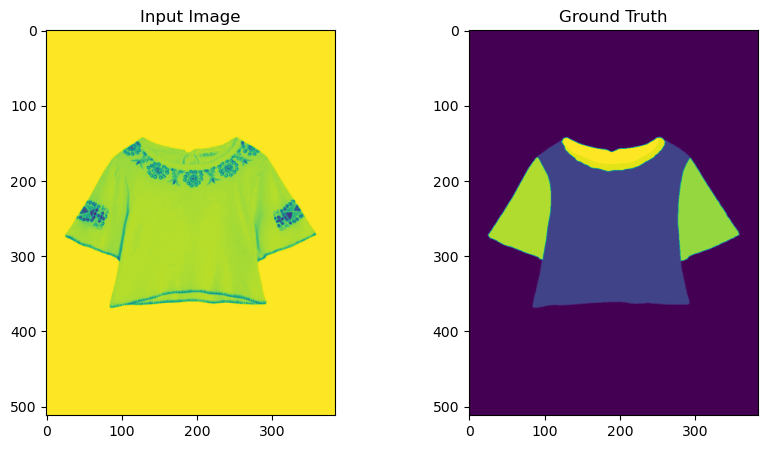

In [6]:
# Description of dataloader
# DataLoader is used to load the data in batches
# It is used to load the data in parallel using multiprocessing workers
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

print(f'Train size: {len(train_dataset)}, Test size: {len(test_dataset)}')
print(f"Length of train_dataset: {len(train_dataset)}")

# Get the example image from the train dataset
first_image_train, first_image_gt = train_dataset[1]
print(f'Shape of the images: {first_image_train.shape}')

# Plot the first image side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(first_image_train.permute(1, 2, 0))
axes[0].set_title('Input Image')
axes[1].imshow(first_image_gt.permute(1, 2, 0))
axes[1].set_title('Ground Truth')


plt.show()

In [7]:
# The diagram is provided to understand the architecture
# The architecture is based on the SegNet model
# The SegNet model is used for semantic segmentation
# The model consists of an encoder and a decoder
# The encoder is used to extract features from the input image
# The decoder is used to generate the output image
from architecture.segnet import SegNet

model = SegNet(in_channels=1, out_channels=1).to(device)
model = DataParallel(model)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

d:\anaconda\Lib\site-packages\torch\nn\parallel\data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [8]:
# The code to make sure the model input and output are correct, we can test the first batch to fed into the network
# data = next(iter(dataloader_train))

# test_data = data[0]
# output_test = model(test_data.to(device))
# print(output_test.shape)

In [9]:
from tqdm import tqdm
from torchvision.utils import save_image
import datetime
import pytz     

class Engine(object):
    def __init__(self, model, optimizer, device, ema=None):
        # Initialize the Engine with the model, optimizer, and the device it's running on.
        self.model = model
        self.optimizer = optimizer
        self.device = device
        # Current epoch of training.
        self.cur_epoch = 0
        # Number of iterations the training has run.
        self.cur_iter = 0
        # The best validation epoch, used to track the epoch with the best validation performance.
        self.bestval_epoch = 0
        # Lists to track the training and validation losses.
        self.train_loss = []
        self.val_loss = []
        # Criterion for calculating loss. Here, it's Mean Squared Error Loss for regression tasks.
        self.criterion = torch.nn.L1Loss() #RMSELoss() #torch.nn.MSELoss()   

    """ Block to begin training """
    def train(self, dataloader_train):
        loss_epoch = 0.
        num_batches = 0
        # Set the model to training mode.
        self.model.train()
        
        # Train loop
        # tqdm is used to display the training progress for each epoch.
        pbar = tqdm(dataloader_train, desc='Train Epoch {}'.format(self.cur_epoch))
        for data in pbar:
            # efficiently zero gradients
            # Zero the gradients before running the backward pass.
            self.optimizer.zero_grad(set_to_none=True)
            images = data[0].to(self.device, dtype=torch.float32)   # Image that will be fed into network
            gt_mass = data[1].to(self.device, dtype=torch.float32)  # Ensure gt_mass is a float tensor, The ground truth of mass

            # Pass the images through the model to get predictions.
            pred_mass = self.model(images)

            # Calculate the loss, backpropagation, and optimization
            loss = self.criterion(pred_mass, gt_mass)
            loss.backward()
            # Perform a single optimization step (parameter update).
            self.optimizer.step()

            # Aggregate the loss for the epoch
            loss_epoch += float(loss.item())
            num_batches += 1

            pbar.set_description("Loss: {:.8f}".format(loss.item()))
            
        pbar.close()
        avg_loss = loss_epoch / num_batches
        self.train_loss.append(avg_loss)

        self.cur_epoch += 1
        pbar.set_description("Epoch: {}, Average Loss: {:.8f}".format(self.cur_epoch, avg_loss))
        
        # Store the formatted time for Israel
        israel_time_zone = pytz.timezone('Israel')
        current_time = datetime.datetime.now(israel_time_zone)
        formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

        # Print Israel time along with training information
        print("Training: Epoch: {}, Average Loss: {:.8f}, Israel Time: {}".format(self.cur_epoch + TrainedEpochCountModel, avg_loss, formatted_time))

        # Append training information along with Israel time to the log file
        with open("note_logs.txt", "a") as log_file:
            log_file.write("Training Epoch: {}, Average Loss: {:.8f} - Israel Time: {}\n".format(self.cur_epoch + TrainedEpochCountModel, avg_loss, formatted_time))


    def test(self, dataloader_test):
        self.model.eval()
        loss_epoch = 0.
        num_batches = 0
        
        # Create a directory for the current epoch's results
        epoch_result_dir = os.path.join(resultdir, str(self.cur_epoch))
        os.makedirs(epoch_result_dir, exist_ok=True)

        # Prepare to collect predictions and ground truth
        with torch.no_grad():  # No need to calculate gradients
            pbar = tqdm(dataloader_test, desc='Test Epoch {}'.format(self.cur_epoch))
            for batch_idx, data in enumerate(pbar):
                images = data[0].to(self.device, dtype=torch.float32)
                gt_mask = data[1].to(self.device, dtype=torch.float32)

                pred_mask = self.model(images)

                loss = self.criterion(pred_mask, gt_mask)
                loss_epoch += float(loss.item())
                num_batches += 1
                pbar.set_description("Test Loss: {:.8f}".format(loss.item()))
                
                for idx, pred in enumerate(pred_mask):
                    save_image(pred, os.path.join(epoch_result_dir, f'prediction_{batch_idx}_{idx}.png'))

        avg_loss = loss_epoch / num_batches
        self.val_loss.append(avg_loss)
        
        # Store the formatted time for Israel
        israel_time_zone = pytz.timezone('Israel')
        current_time = datetime.datetime.now(israel_time_zone)
        formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
        
        print(f"Test Epoch: {self.cur_epoch + TrainedEpochCountModel}, Average Loss: {avg_loss:.8f}, Israel Time: {formatted_time}")
        with open("note_logs.txt", "a") as log_file:
            log_file.write(f"Testing Epoch: {self.cur_epoch + TrainedEpochCountModel}, Average Loss: {avg_loss:.8f}, Israel Time: {formatted_time}\n")

        return avg_loss


In [10]:
import os
print(os.getcwd())

from codes.scheduler import CyclicCosineDecayLR

# The scheduler is used to reduce the learning rate at specific epochs
if scheduler:
	scheduler = CyclicCosineDecayLR(optimizer,
	                                init_decay_epochs=80,
	                                min_decay_lr=2.5e-6,
	                                restart_interval = 10,
	                                restart_lr=12.5e-5,
	                                warmup_epochs=20,
	                                warmup_start_lr=2.5e-6)


trainer = Engine(model, optimizer, device, ema=None)

# Load the saved model if load_saved_model is set to True
if load_saved_model:
	model.load_state_dict(torch.load('logs/final_model.pth'))
 
# Count the total number of trainable parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print ('======Total trainable parameters: ', params)

for epoch in range(trainer.cur_epoch, training_epoch):
	trainer.train(dataloader_train)

	# Test the model every 3 epochs and save it to logs/results folder, also save the model to logs/final_model.pth
	if (epoch) % 10 == 0:
		trainer.test(dataloader_test)
	
	torch.save(model.state_dict(), os.path.join('logs', 'final_model.pth'))
	
	if scheduler:
		scheduler.step()


d:\Downloads\fresh_projects\SegmAIParserClothes
start
======Total trainable parameters:  29442433


Loss: 0.32913911: 100%|██████████| 499/499 [00:55<00:00,  8.95it/s]


Epoch: 1, Average Loss: 0.40385565


Test Loss: 0.33374211: 100%|██████████| 1/1 [00:00<00:00,  9.80it/s]


Test Epoch: 1, Average Loss: 0.33374211


Loss: 0.19776329: 100%|██████████| 499/499 [00:53<00:00,  9.34it/s]


Epoch: 2, Average Loss: 0.25786231


Loss: 0.07111304:  79%|███████▉  | 393/499 [00:43<00:11,  9.33it/s]